In [1]:
library(tidyverse)
library(DESeq2)
library(sva)

source("../../utils/plots_eda.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

# Fed Correction ...

... after FC app ...

In [ ]:
path_to_fed <- "/home/yuliya/repos/cosybio/FedComBat/datasets/Breast_cancer_RNASeq/after/fed_res/"
zip_files <- list.files(path = path_to_fed, pattern = "\\.zip$", full.names = TRUE)

for(i in seq_along(zip_files)) {
  zipfile <- zip_files[i]
  zip_contents <- unzip(zipfile, list = TRUE)$Name
  csv_files <- zip_contents[grepl("\\.csv$", zip_contents, ignore.case = TRUE)]
  
  # If no CSV file is found, skip this zip
  if(length(csv_files) == 0) {
    warning(sprintf("No CSV file found in zip: %s", zipfile))
    next
  }
  csv_to_extract <- csv_files[1]
  new_csv_name <- file.path(path_to_fed, sprintf("%d_bayes_data.csv", i))
  unzip(zipfile, files = csv_to_extract, exdir = path_to_fed)
  
  # Determine the path to the extracted file (handles potential subdirectories)
  extracted_csv_path <- file.path(path_to_fed, csv_to_extract)
  
  # If the extracted file is inside a subdirectory, move it to the main folder
  if (!file.exists(extracted_csv_path)) {
    # Sometimes the unzip creates subfolders. List files recursively.
    extracted_files <- list.files(path_to_fed, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
    # Find the matching file (by comparing filenames ignoring directory structure)
    candidate <- extracted_files[basename(extracted_files) == basename(csv_to_extract)]
    if(length(candidate) > 0) {
      extracted_csv_path <- candidate[1]
    } else {
      warning(sprintf("Extracted CSV file not found for zip: %s", zipfile))
      next
    }
  }
  
  # Rename (or move) the extracted CSV file to the new filename
  if(!file.rename(from = extracted_csv_path, to = new_csv_name)) {
    warning(sprintf("Failed to rename file: %s", extracted_csv_path))
  }
}


In [ ]:
fed_expression <- NULL

for(i in 1:3){
    expr_data <- read.table(paste0(path_to_fed, i, "_bayes_data.csv"), header = TRUE, sep = "\t")
    print(paste0("Samples: ", ncol(expr_data), "; Features: ", nrow(expr_data)))
    # save data
    if(is.null(fed_expression)){
        fed_expression <- expr_data
    } else {        
        fed_expression <- full_join(fed_expression, expr_data, by = "gene_id")
    }
    print(paste0("Combined Samples: ", ncol(fed_expression), "; Features: ", nrow(fed_expression)))
    print(" ")
}


In [ ]:
# write to file
write.table(fed_expression, file = "after/fed_combined_data.csv", sep = "\t", 
            row.names = FALSE, col.names = TRUE, quote = FALSE)

# Load data

In [6]:
all_metadata <- read.table("before/all_design.tsv", header = TRUE, sep = "\t")
all_metadata$Status <- all_metadata$lum
all_metadata$Dataset <- as.character(all_metadata$batch)

In [7]:
corrected_expr <- read.table(
    "/home/yuliya/repos/cosybio/FedComBat/datasets/Breast_cancer_RNASeq/after/all_corrected_R_expr.tsv", 
    header = TRUE, sep = "\t")

corrected_expr <- corrected_expr %>% column_to_rownames("gene_id") 
print(paste0("Samples: ", ncol(corrected_expr), "; Features: ", nrow(corrected_expr)))
corrected_expr <- corrected_expr[, all_metadata$sample_id]


[1] "Samples: 131; Features: 28823"


In [8]:
fed_expression <- read.table(
    "/home/yuliya/repos/cosybio/FedComBat/datasets/Breast_cancer_RNASeq/after/fed_combined_data.csv", 
    header = TRUE, sep = "\t")

fed_expression <- fed_expression %>% column_to_rownames("gene_id") 
print(paste0("Samples: ", ncol(fed_expression), "; Features: ", nrow(fed_expression)))
fed_expression <- fed_expression[rownames(corrected_expr), all_metadata$sample_id]


[1] "Samples: 131; Features: 28823"


In [9]:
# plot the combined data
print("Plotting combined data")
plot_res <- plot_diagnostic(fed_expression, all_metadata, "FedCombat corrected",
                            log_transform = TRUE, with_rowname = TRUE)
layout <- (plot_res[[1]] + plot_res[[2]] ) / 
          (plot_res[[3]] )
ggsave("after/diagnostic_plot_correcter_Fed.png", 
            plot = layout, width = 12, height = 12)

[1] "Plotting combined data"


[1] "..plotting.."


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
No id variables; using all as measure variables



# Min Max and mean absolute error

In [10]:
# Calculate value-to-value mean, max, and mean absolute difference
mean_diff <- mean(as.matrix(abs(corrected_expr - fed_expression), na.rm = TRUE))
max_diff <- max(abs(corrected_expr - fed_expression), na.rm = TRUE)
min_diff <- min(abs(corrected_expr - fed_expression), na.rm = TRUE)

print(paste0("Min difference: ", min_diff))
print(paste0("Mean difference: ", mean_diff))
print(paste0("Max difference: ", max_diff))


[1] "Min difference: 0"
[1] "Mean difference: 1.24195999808576e-14"
[1] "Max difference: 3.59934304583476e-13"


NULL

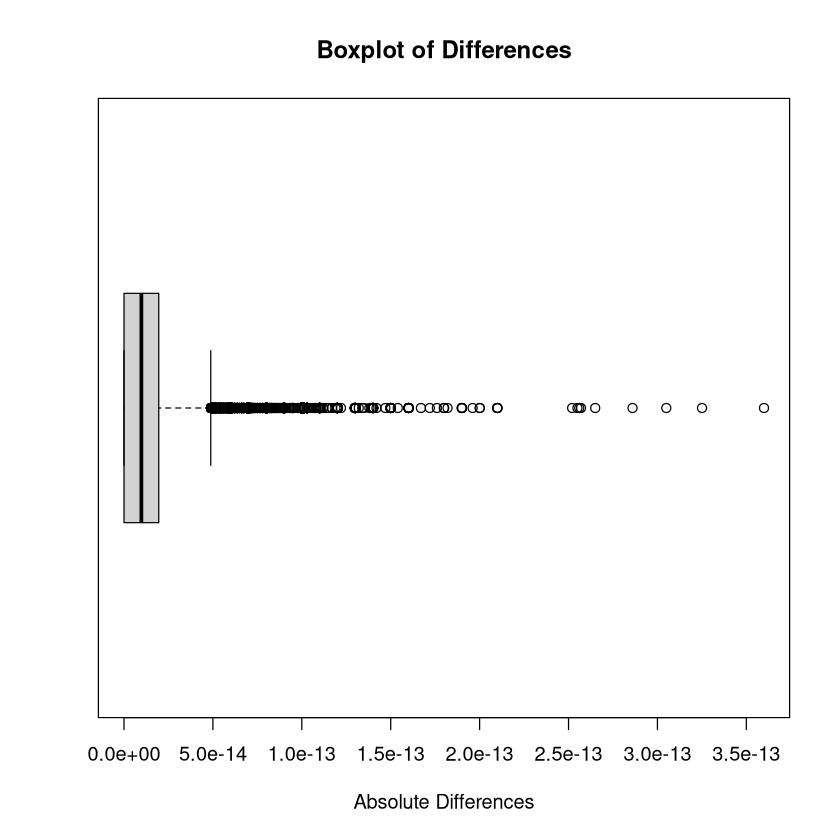

In [11]:
boxplot(abs(as.numeric(unlist(corrected_expr)) - as.numeric(unlist(fed_expression))),
        main = "Boxplot of Differences", xlab = "Absolute Differences",
        # add values to the plot - for the mean and the median
        horizontal = TRUE) +
    theme_minimal()
